In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # 2D plotting library (www.matplotlib.org)
import numpy as np # library for efficient numerical computing with arrays (www.numpy.org)
import pygimli as pg # *G*eophysical *I*nversion and *M*odeling *Li*brary (www.pygimli.org)
import pygimli.meshtools as mt
#import pybert as pb
import pygimli.physics.ert as ert
from pygimli.physics import ERTManager
import pygimli.physics.petro as pet

# Calculations and values

## world dimensions: 
x-direction [m]: 0 - 34  
y-direction [m]: -3 - 20  

## hydraulic potential:
solve Darcy with Finite Elements for hydraulic head distribution [m]:  
$$\nabla \cdot (K \nabla h) = 0$$  
h1 [m] = 16\
h2 [m] = 10\
h3 [m] = 2\
h4 [m] = -1

boundary conditions (Dirichlet):\
left upper gravel layer: h1, right upper gravel layer: h2\
left lower gravel layer: h3, right lower gravel layer: h4

hydraulic conductivity K [m/s]:  
upper and lower sandstone layer (markers 1 & 3): $2 \cdot 10^{-7}$  
upper and lower gravel aquifers (markers 2 & 4): $10^{-3}$  
limestone, dolomite rock (marker 5): $10^{-7}$  
clean sand body (marker 6): $8 \cdot 10^{-3}$

velocity v [m/s]: $\textbf{v} = \frac{-K \nabla h} {\phi}$  
$\textbf{v}_{abs} = \sqrt{\textbf{v}_x^2 + \textbf{v}_y^2}$  
porosity $\phi$ = 0.3  
## streaming potential:
solve streaming potential equation with Finite Elements for streaming potential $\varphi$ [V]:  
$$\nabla \cdot (\sigma \nabla \varphi) = \nabla \cdot (L \textbf{v})$$  
L = 10  

$\varphi1$ [V] = 0<br>
$\varphi2$ [V] = 0.01<br>
$\varphi3$ [V] = 0.1<br>
boundary conditions (Dirichlet):<br>
upper left gravel layer: $\varphi1$<br>
upper right gravel layer: $\varphi3$<br>
limestone, dolomite rock: $\varphi3$<br>

electrical conductivity $\sigma$ [S/m]:<br>
upper sandstone layer: $7 \cdot 10^{-4}$<br> 
upper gravel layer: $9 \cdot 10^{-4}$<br>
lower sandstone layer: $10^{-4}$<br>
lower gravel layer: $4 \cdot 10^{-4}$<br> 
limestone, dolomite rock: $3 \cdot 10^{-1}$<br>
clean sand body: $3 \cdot 10^{-1}$<br>
## tracer transport:
solve transport equation with Finite Volume for concentration c [g/l]:  
$$\frac{\partial c}{\partial t} = \underbrace{\nabla\cdot(D \nabla c)}_{\text{Diffusion / Dispersion}} - \underbrace{\mathbf{v}\nabla c}_{\text{Advection}} + S$$
2 tracer injection positions S[x,y]: <br>
position1 = [2,16] <br>
position2 = [5,0]   <br>
injection load 1 [mg/l]: 5<br>
injection load 2 [mg/l]: 12.5<br>
dispersion rate D [m/s]: D = $\alpha \cdot \textbf{v}_{abs}$  
$\alpha = 10^{-3}$  
##### timestepping:
steps: 5000  
timeperiod [days] = 5  
intervall $\Delta t$ = timeperiod[sec]/(steps-1) = 86.417 sec  
injections stopped after: steps/2  
#### CFL criterion:  
$\Delta x$ = 0.11809 m <br>
$v_{max}$ = 0.00127 m/s  <br>
cfl-criterium = $\frac{v_{max} \Delta t} {\Delta x}$ = 0.9312  <br>
## electrical conductivity:
$\sigma_0$ [S/m] = 0.01  
$\sigma_W =$ 0.1$ c + \sigma_0$ 
## electrical resitivity tomography (ERT):
Archie's equation for $\rho_b$ [$\Omega m$]:  
$$\rho_b = a \cdot (1/\sigma_W)\cdot\phi^{-m}\cdot S^{-n}$$ 
a=1  
m=2  
S=1  
n=2  
measurement array: dipole-dipole<br>
from 0 - 34m<br>
dx = 1.0m<br>

# Create world with geometry

(<AxesSubplot:>, None)

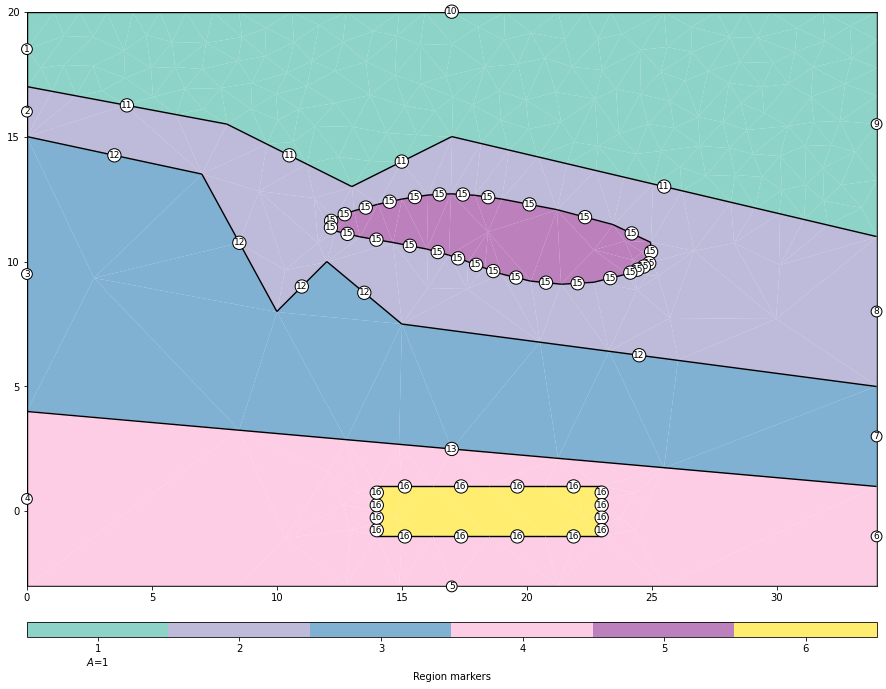

In [86]:
layer1 = mt.createPolygon([[0.0, 20], [34, 20], [34, 11], [17, 15], [13, 13], [8, 15.5], [0.0, 17]],
                          isClosed=True, boundaryMarker=[10,9,11,11,11,11,1], marker = 1,area=1)
layer2 = mt.createPolygon([[0.0, 17], [8,15.5], [13, 13], [17,15], [34, 11], [34, 5], [15, 7.5], [12, 10], 
                           [10, 8], [7, 13.5], [0, 15]],
                          isClosed=True, boundaryMarker=[11,11,11,11,8,12,12,12,12,12,2], marker = 2)
layer3 = mt.createPolygon([[0.0, 15], [7, 13.5], [10, 8], [12, 10], [15, 7.5], [34, 5], [34, 1], [0, 4]],
                          isClosed=True, boundaryMarker=[12,12,12,12,12,7,13,3], marker = 3)
layer4 = mt.createPolygon([[0, 4], [34, 1], [34, -3], [0, -3]],
                          isClosed=True, boundaryMarker=[13,6,5,4], marker = 4)
rock = mt.createPolygon([(12,11.5), (15,12.5), (19,12.5), (25,10),
                         (24,9.5), (19,9.5), (16,10.5)], isClosed=True,
                         addNodes=3, interpolate='spline', boundaryMarker=15, marker = 5)
rock2 = mt.createPolygon([(14,1), (23,1), (23,-1), (14,-1)], isClosed=True,
                         addNodes=3, boundaryMarker=16, marker = 6)
geometry = mt.mergePLC([layer1, layer2, layer3, layer4, rock, rock2])
#plotting:
fig,ax = plt.subplots(1,1,figsize=(17, 11.5))
ax.tick_params(labelsize=15)
pg.show(geometry, ax=ax, boundaryMarker=True)

## Quality test

(<AxesSubplot:>, None)

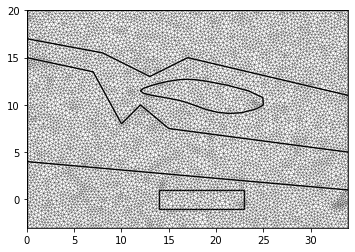

In [41]:
mesh = mt.createMesh(geometry, quality=33.4, markers = True, area=0.1, smooth = [1,10])
pg.show(mesh)

C:\Users\michi\Anaconda3\envs\pg\lib\site-packages\pygimli\viewer\mpl\colorbar.py:434: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  mappable.get_cmap().set_bad([1.0, 1.0, 1.0, 0.0])


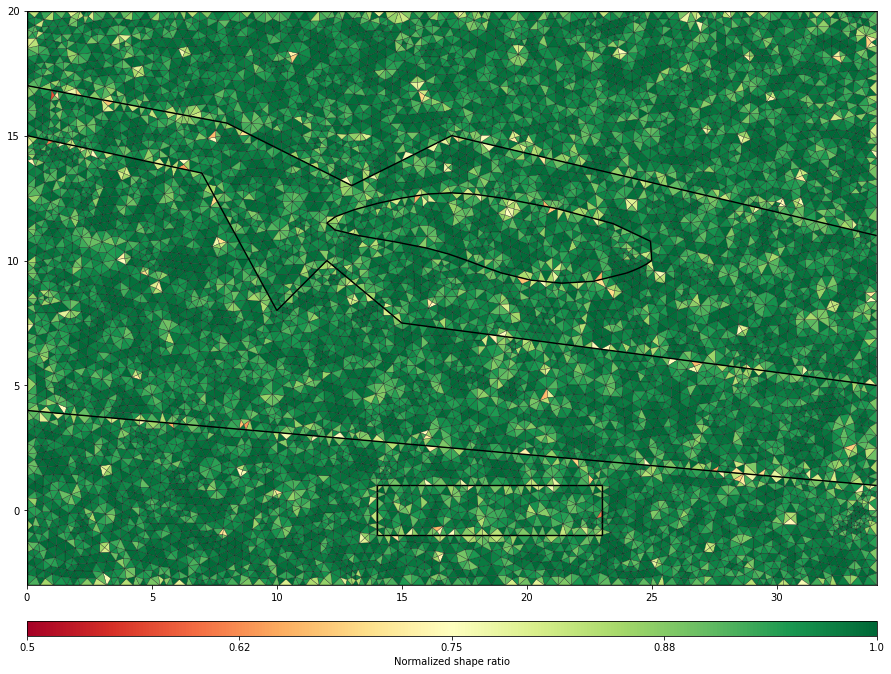

In [10]:
qual = mt.quality(mesh, "nsr")
fig,ax = plt.subplots(1,1,figsize=(17, 11.5))
pg.show(mesh, qual, ax=ax, cMap="RdYlGn", showMesh=True, hold=True, cMin=0.5, cMax=1.0, label="Normalized shape ratio")

# 1. hydraulic potential

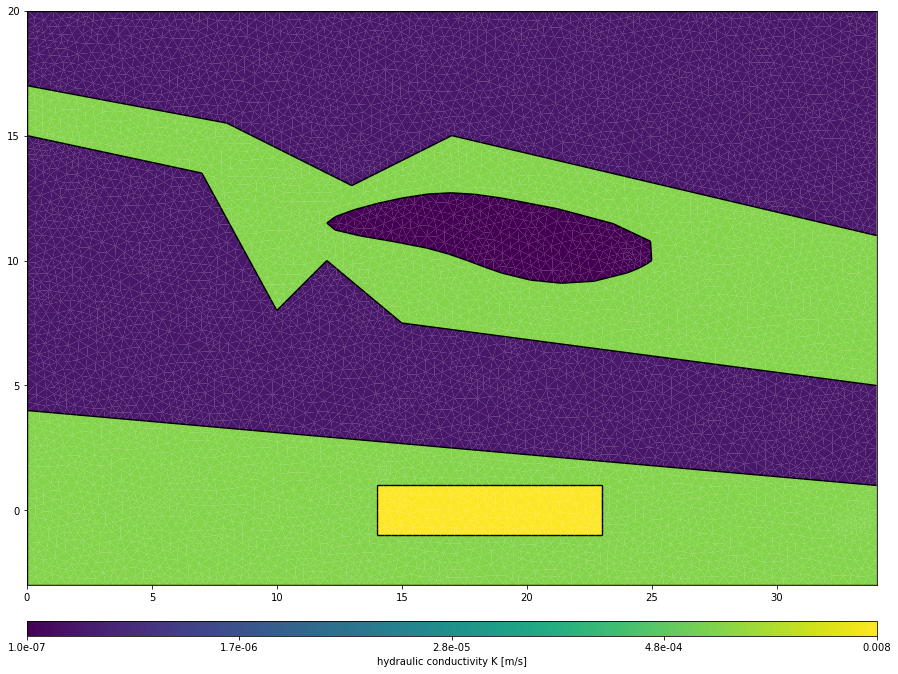

In [13]:
#hydraulic potentials h:
kMap = [[1, 2e-7], [2, 1e-3], [3, 2e-7], [4, 1e-3], [5, 1e-7], [6, 8e-3]] #m/s
h1 = 16 #m
h2 = 10 #m
h3 = 2 #m
h4 = -1 #m
bc = {"Dirichlet": {2: h1, 4: h3, 6: h4, 8: h2}}
#hydraulic conductivity K:
K = pg.solver.parseMapToCellArray(kMap, mesh)
K = np.array(K)
fig,ax = plt.subplots(1,1,figsize=(17, 11.5))
pg.show(mesh, K , ax=ax, label="hydraulic conductivity K [m/s]", logScale=True, grid=True)

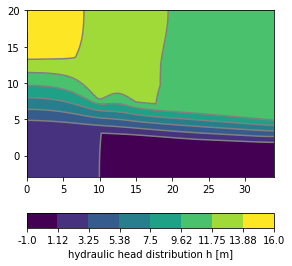

In [15]:
from Darcy import solveDarcy
h = solveDarcy(mesh, K, bc)

In [16]:
from pygimli.viewer.pv import drawStreamLines, drawSlice

In [17]:
por = 0.3
grad_h = pg.solver.grad(mesh, h)
v = ((-K*grad_h.T).T)/por #m/s
v_x = v[:,0] #m/s
v_y = v[:,1] #m/s
v_z = v[:,2] #m/s
v_abs = abs(np.sqrt((v_x**2+v_y**2))) #m/s

In [18]:
print(max(v_abs),min(v_abs))

0.0013167140350592793 2.884123224584988e-09


(<AxesSubplot:>, None)

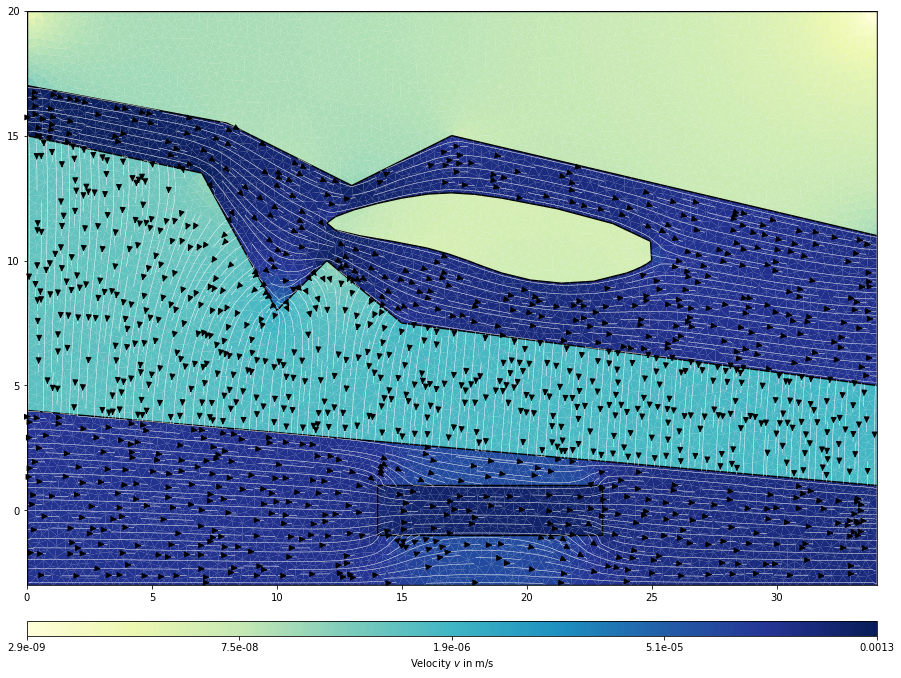

In [24]:
#plotting:
fig, axes = plt.subplots(figsize =(17, 11.5))
ax, _ = pg.show(mesh, data= v_abs, logScale = True, ax=axes, cMap='YlGnBu',
                label= "Velocity $v$ in m$/$s", hold=True)
pg.show(mesh, v, ax=ax, color = 'w', linewidth = 0.5, dropTol=5e-7)

# 2. streaming potential

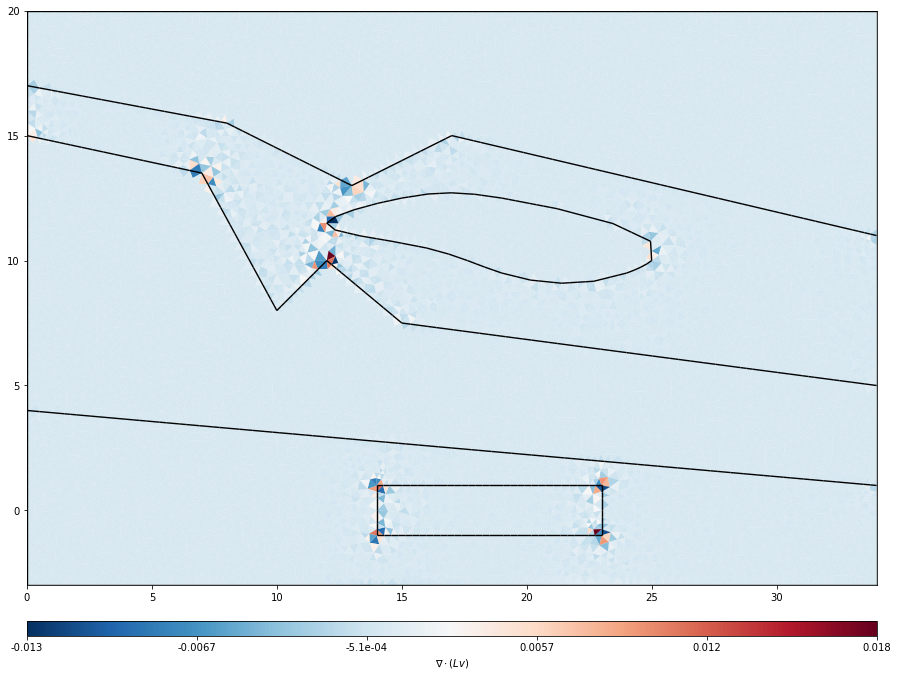

In [50]:
L = 10
rhs = pg.solver.div(mesh, L*v)
#ax, _ = pg.show(mesh, v, hold=True)

fig, axes = plt.subplots(figsize =(17, 11.5))
ax, _ = pg.show(mesh, rhs, ax=axes, cMap='RdBu_r',
                label= r"$\nabla \cdot (Lv)$", hold=True, nLevs = 6)

(<AxesSubplot:xlabel='$\\nabla \\cdot (\\nabla h)$'>,
 <matplotlib.colorbar.Colorbar at 0x1c198a37b08>)

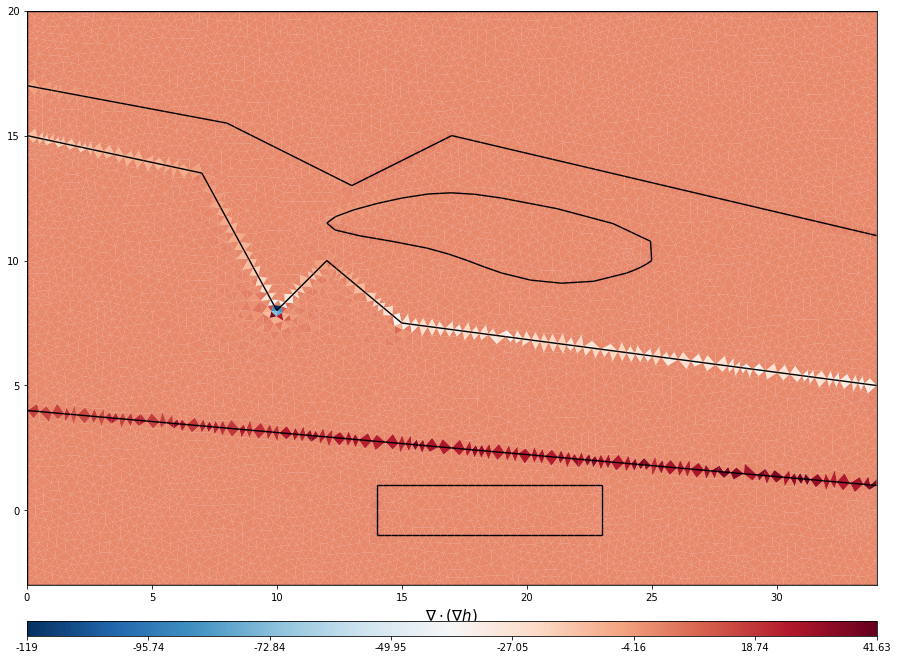

In [51]:
lhs = pg.solver.div(mesh, grad_h/por)
fig, ax = plt.subplots(figsize =(17,11.5))
ax.set_xlabel(r"$\nabla \cdot (\nabla h)$", fontsize="15")
pg.show(mesh, lhs, ax=ax, hold = True, nLevs = 8, cMap = "RdBu_r")

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x1c194e15348>)

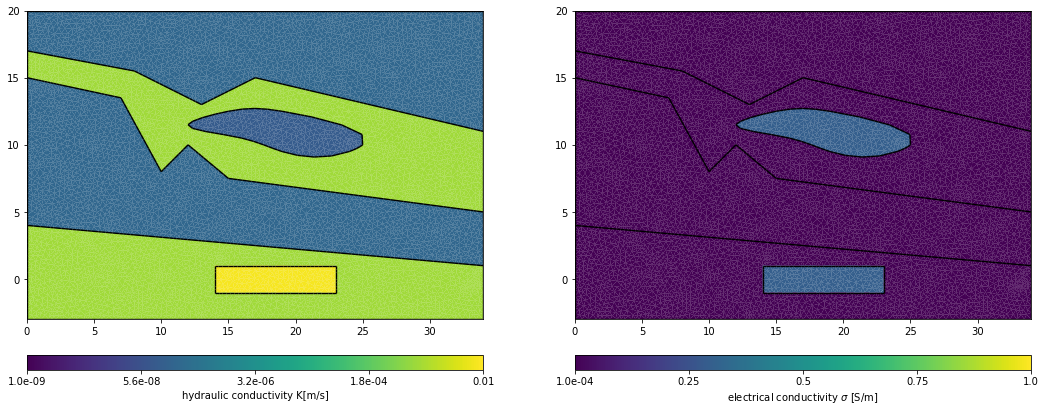

In [44]:
#streaming potentials:
phi1 = 0 #V
phi2 = 0.01 #V
phi3 = 0.1 #V
bc_lhs = {"Dirichlet": {2: phi1, 8: phi3, 15: phi2}}

#electrical conductivity sigma:
sigma = pg.solver.parseMapToCellArray([[1,7e-4],[2,9e-4],[3,1e-4],[4,4e-4],[5,3e-1],[6,3e-1]], mesh)
sigma = np.array(sigma)
fig,ax = plt.subplots(1,2,figsize=(18, 9))
pg.show(mesh, K , cMin=1e-9, cMax=0.01, logScale = True, ax=ax[0],hold=True, label="hydraulic conductivity K[m/s]")
pg.show(mesh, sigma, cMin=0.0001, cMax=1, ax=ax[1], hold=True, label=r"electrical conductivity " r"$\sigma$ [S/m]")

17/10/20 - 14:14:03 - pyGIMLi - WARNING - Keyword argument name changed from 'cmap' to 'cMap'


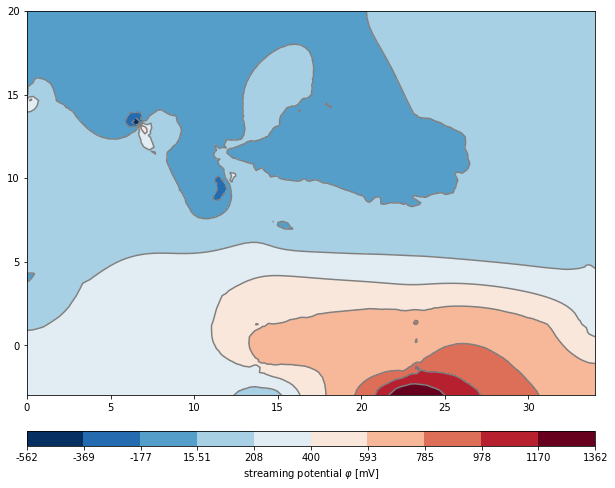

In [53]:
from StreamPotential import solveStreampot
phi,E = solveStreampot(mesh, sigma, bc_lhs, rhs)

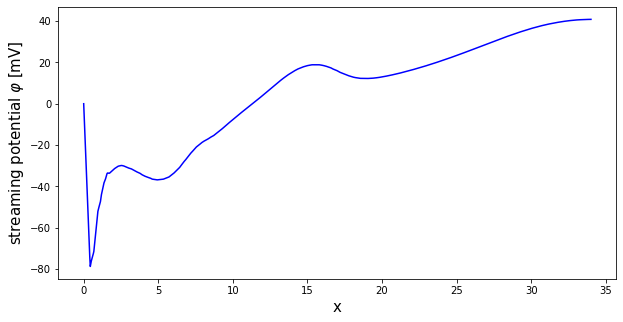

In [54]:
depth = 3
phi = np.array(phi)
x = np.linspace(mesh.xmin(),mesh.xmax(),1000)
x2 = [[i,mesh.ymax()-depth] for i in x]
phi_x = pg.interpolate(mesh,phi,x2)
fig, ax = plt.subplots(figsize =(10,5))
ax.plot(x, phi_x*1000,"b")
ax.set_ylabel(r"streaming potential " r"$\varphi$ [mV]",fontsize="15")
ax.set_xlabel('x',fontsize="15")

# 3. tracer transport

13984
<pygimli.core._pygimli_.Triangle object at 0x000001C197DA28F0>	ID: 10443, Marker: 1, Size: 0.06515042609617024
	5312 RVector3: (2.0478673842955586, 18.258025883054703, 0.0)
	5309 RVector3: (1.7638344897043765, 17.893726552736876, 0.0)
	5313 RVector3: (2.087059278741758, 17.849540550893796, 0.0)

0.38372734451647106
0.10460606595438625
0.37791768024289807


C:\Users\michi\Anaconda3\envs\pg\lib\site-packages\pygimli\viewer\mpl\colorbar.py:434: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  mappable.get_cmap().set_bad([1.0, 1.0, 1.0, 0.0])


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x1c19c0c2448>)

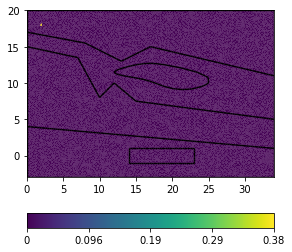

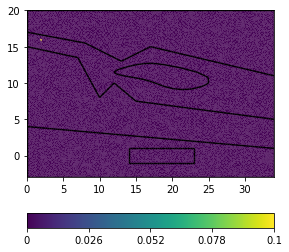

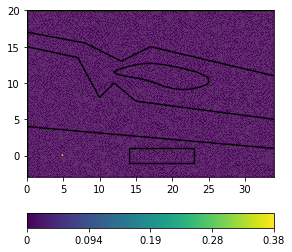

In [56]:
S1 = np.zeros(mesh.cellCount())
S2 = np.zeros(mesh.cellCount())
S3 = np.zeros(mesh.cellCount())
print(mesh.cellCount())
inj_pos1 = [2,18]
inj_pos2 = [2,16]
inj_pos3 = [5,0]
cell1 = mesh.findCell(inj_pos1)
cell2 = mesh.findCell(inj_pos2)
cell3 = mesh.findCell(inj_pos3)
start1 = cell1.id()
start2 = cell2.id()
start3 = cell3.id()
#print(cell1.size())
#print(cell2.size())
#print(cell3.size())
S1[start1] = 25*0.001/cell1.size() # in [g/(l*s)]
S2[start2] = 5*0.001/cell2.size() # in [g/(l*s)]
S3[start3] = 12.5*0.001/cell3.size() # in [g/(l*s)]
print(cell1)
print(S1[start1])
print(S2[start2])
print(S3[start3])
pg.show(mesh, S1, label='')
pg.show(mesh, S2, label='')
pg.show(mesh, S3, label='')

In [57]:
alpha = 1e-3
D = alpha*v_abs #m/s
print(D)

[4.46945499e-07 1.26850327e-07 9.82212513e-08 ... 1.53236417e-10
 8.56435760e-11 1.24055456e-10]


In [65]:
steps = 5000
timeperiod = 5*24*3600 #in sec
del_t = timeperiod/(steps-1) #in sec
del_t_h = del_t/3600 #in hours
print(del_t, del_t_h)
#np.savetxt("del_t", [del_t])
times = np.linspace(0,timeperiod,steps) # seconds-vector
ht1 = times[:int(steps*0.15)]
ht2 = times[ht1.size:int(steps*0.25)]
ht3 = times[ht2.size:int(steps*0.5)]
ht4 = times[ht3.size:len(times)]

86.41728345669134 0.024004800960192037


In [59]:
#test CFL:
read_dx = 0.11809387587202069 # taken from output below (cell size)
cfl = v.max()*del_t/read_dx
print(v.max(),cfl)

0.0012725067081941197 0.9311793019794196


In [66]:
from Transport import solveTransport
#c = solveTransport(mesh, D, v, S, ht)
from pygimli.solver import solveFiniteVolume as solveFV
c1 = solveFV(mesh, a = D, scheme="PS", vel = v, f = 0, times = ht1)
c2 = solveFV(mesh, a = D, scheme="PS", vel = v, f = S2+S3, times = ht2, u0 = c1[-1])
c3 = solveFV(mesh, a = D, scheme="PS", vel = v, f = S2+S3, times = ht3, u0 = c2[-1])
c4 = solveFV(mesh, a = D, scheme="PS", vel = v, f = 0, times = ht4, u0 = c3[-1])
c = np.vstack([c1,c2,c3,c4])

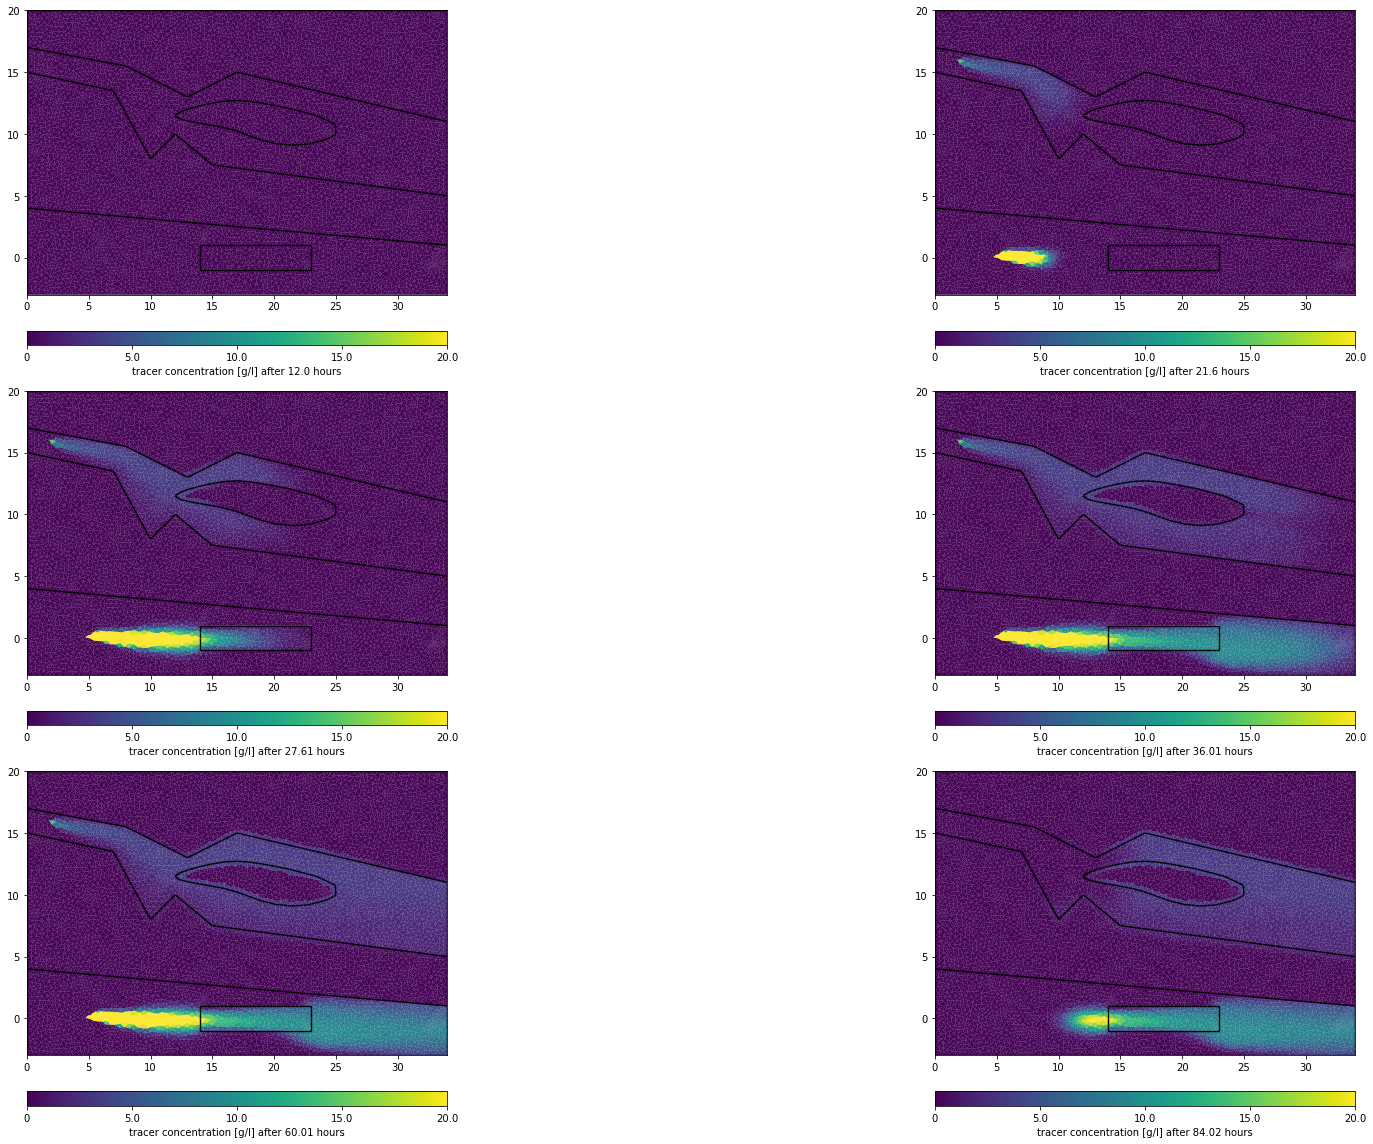

In [70]:
frames = [round(steps*0.1),round(steps*0.18),round(steps*0.23),round(steps*0.3),round(steps*0.5),round(steps*0.7)]
fig, axes = plt.subplots(3,2,figsize =(32,16))

pg.show(mesh, c[frames[0]], cMin = 0, cMax = 20, label = "tracer concentration [g/l] after {} hours".format(round(frames[0]*del_t_h,2)),
        ax=axes[0,0], hold=True)
pg.show(mesh, c[frames[1]], cMin = 0, cMax = 20, label = "tracer concentration [g/l] after {} hours".format(round(frames[1]*del_t_h,2)), 
        ax=axes[0,1], hold=True)
pg.show(mesh, c[frames[2]], cMin = 0, cMax = 20, label = "tracer concentration [g/l] after {} hours".format(round(frames[2]*del_t_h,2)), 
        ax=axes[1,0], hold=True)
pg.show(mesh, c[frames[3]], cMin = 0, cMax = 20, label = "tracer concentration [g/l] after {} hours".format(round(frames[3]*del_t_h,2)),
        ax=axes[1,1], hold=True)
pg.show(mesh, c[frames[4]], cMin = 0, cMax = 20, label = "tracer concentration [g/l] after {} hours".format(round(frames[4]*del_t_h,2)), 
        ax=axes[2,0], hold=True)
pg.show(mesh, c[frames[5]], cMin = 0, cMax = 20, label = "tracer concentration [g/l] after {} hours".format(round(frames[5]*del_t_h,2)), 
        ax=axes[2,1], hold=True)
fig.tight_layout()

In [ ]:
for ci in c[1:][::200]:
    pg.show(mesh, data=ci * 0.001, cMin=0, cMax=3, cMap="magma_r",
            label="Concentration c in $g/l$")

In [28]:
from IPython.display import HTML, clear_output
import matplotlib.animation as animation

In [ ]:
%%capture
# Create animation
fig, ax = plt.subplots()

plot_cfg = {
    "cMin": 1,
    "cMax": 300,
    "logScale": False
}

gci = pg.mplviewer.drawModel(ax, mesh, c[0], **plot_cfg)
pg.mplviewer.createColorBar(gci, label="concentration [$g/l$]", pad=0.55)

def animate(i):
    pg.mplviewer.setMappableData(gci, c[i], **plot_cfg)

# interval is time between frames in ms
anim = animation.FuncAnimation(fig, animate, frames=len(c),
                               interval=50, repeat=False)

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
anim.save('summary_conc_anim.mp4')

# 4. el. conductivity and resistivity

In [72]:
# Your answer here
sigma_0=0.1 # mS/cm
sigma_0=0.1*sigma_0 #S/m
sigma_W = 0.1*c+sigma_0

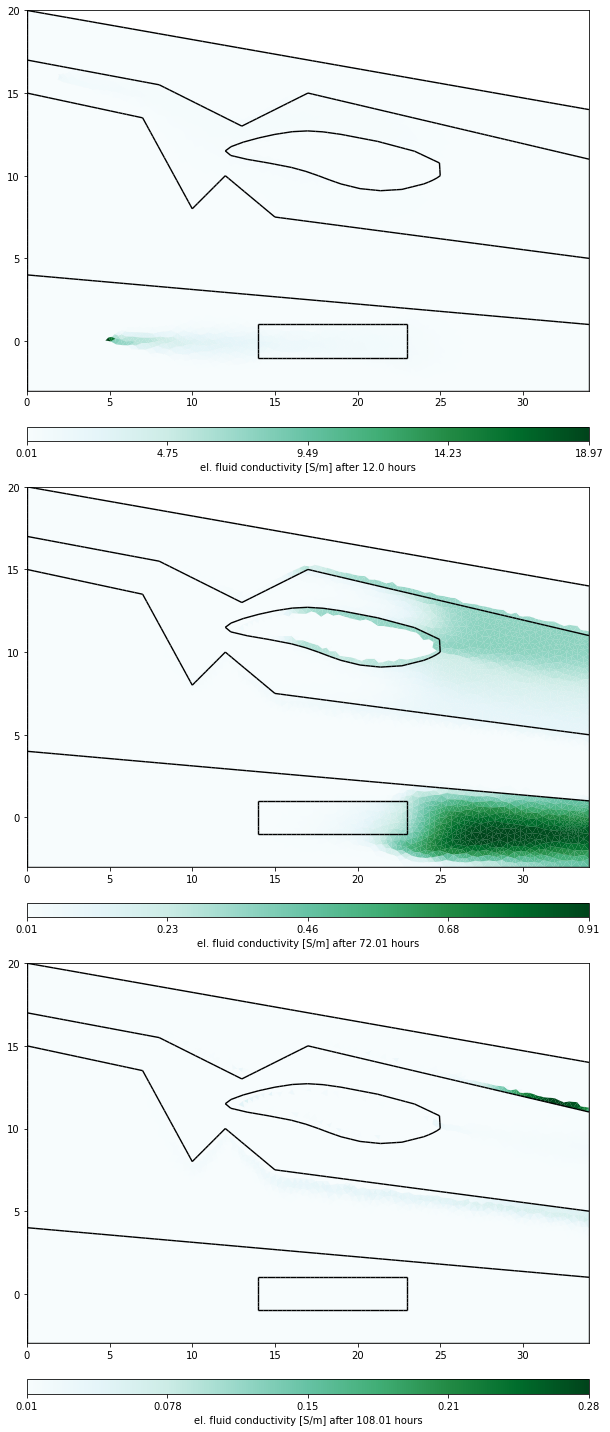

In [23]:
fig,axes = plt.subplots(3,1,figsize =(40,20))
# fluid conductivity:
pg.show(mesh, sigma_W[frames[0]], label = "el. fluid conductivity [S/m] after {} hours".format(round(frames[0]*del_t_h,2)), cMap="BuGn", ax=axes[0], hold=True)
pg.show(mesh, sigma_W[frames[3]], label = "el. fluid conductivity [S/m] after {} hours".format(round(frames[3]*del_t_h,2)), cMap="BuGn", ax=axes[1], hold=True)
pg.show(mesh, sigma_W[frames[5]], label = "el. fluid conductivity [S/m] after {} hours".format(round(frames[5]*del_t_h,2)), cMap="BuGn", ax=axes[2], hold=True)
fig.tight_layout()

# 5: Transform fluid conductivity into bulk resistivity of the rock

In [73]:
# Your answer here
# Archie's equation:
a=1
m=2
n=2
S=1
rho_b = a*(1/sigma_W)*(por**(-m))*(S**(-n))

In [ ]:
from IPython.display import HTML, clear_output
import matplotlib.animation as animation

In [ ]:
%%capture
# Create animation
fig, ax = plt.subplots()

plot_cfg = {
    "cMin": 1,
    "cMax": 1000,
    "logScale": False
}

gci = pg.mplviewer.drawModel(ax, mesh1, rho_b[0], cMap="PuBu", **plot_cfg)
pg.mplviewer.createColorBar(gci, label="resistivity [$\Omega m$]", pad=0.55)

def animate(i):
    pg.mplviewer.setMappableData(gci, rho_b[i], **plot_cfg)

# interval is time between frames in ms
anim = animation.FuncAnimation(fig, animate, frames=len(rho_b),
                               interval=30, repeat=False)

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
#anim.save('summary_roh_anim.mp4')

(<AxesSubplot:>, None)

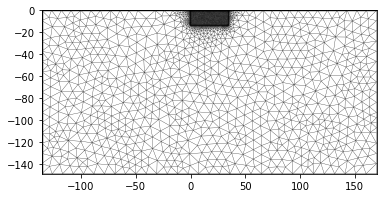

In [75]:
ertScheme = ert.createERTData(pg.utils.grange(0, 34, dx=0.11809387587202069), schemeName='dd')

meshERT = mt.createParaMesh(ertScheme, quality=33, paraMaxCellSize=0.2,
                            boundaryMaxCellSize=50, smooth=[1, 2])
pg.show(meshERT)

In [76]:
# Select 10 time frame to simulate ERT data
timesERT = pg.IVector(np.floor(np.linspace(0, len(c) - 1, 10)))

# Create conductivity of fluid for salt concentration $c$
sigmaFluid = c[timesERT] * 0.1 + 0.01

# Calculate bulk resistivity based on Archie's Law
resBulk = pet.resistivityArchie(rFluid=1. / sigmaFluid, porosity=0.3, m=1.3,
                                  mesh=mesh, meshI=meshERT, fill=1)

# apply background resistivity model
rho0 = np.zeros(meshERT.cellCount()) + 1000.
for cel in meshERT.cells():
    if cel.center()[1] < -8:
        rho0[cel.id()] = 150.
    elif cel.center()[1] < -2:
        rho0[cel.id()] = 500.
resis = pg.Matrix(resBulk)
for i, rbI in enumerate(resBulk):
    resis[i] = 1. / ((1. / rbI) + 1. / rho0)

In [77]:
ERT = ERTManager(verbose=False)
# Run  simulation for  the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme,
                    returnArray=True, verbose=False)

Detecting small distances, using mm accuracy
Detecting small distances, using mm accuracy
Detecting small distances, using mm accuracy
Detecting small distances, using mm accuracy
Detecting small distances, using mm accuracy
Detecting small distances, using mm accuracy
Detecting small distances, using mm accuracy
Detecting small distances, using mm accuracy
Detecting small distances, using mm accuracy
Detecting small distances, using mm accuracy


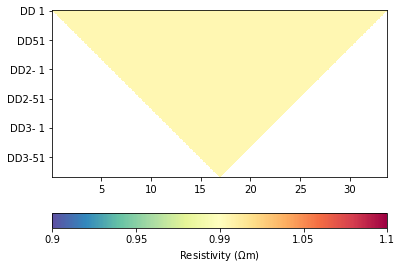

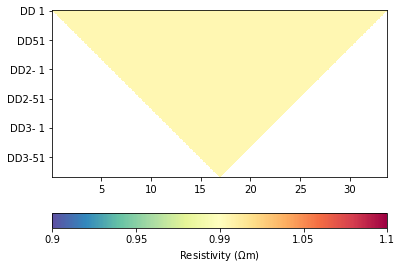

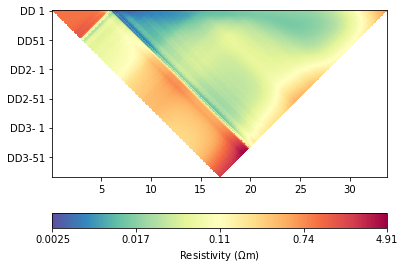

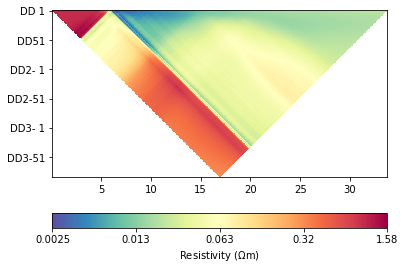

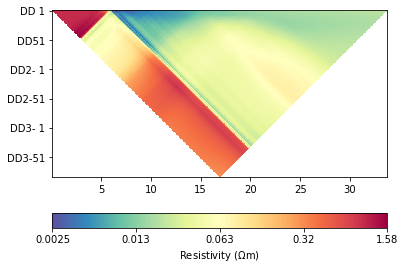

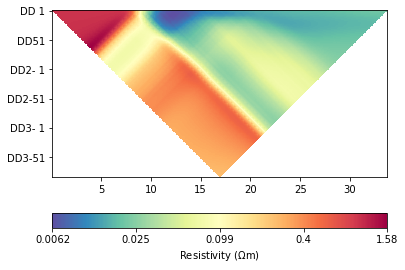

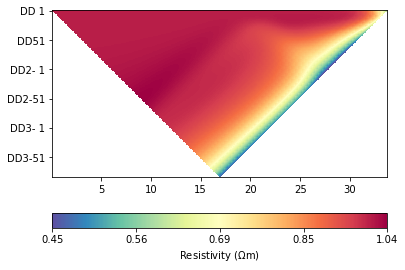

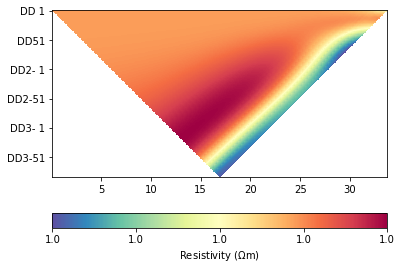

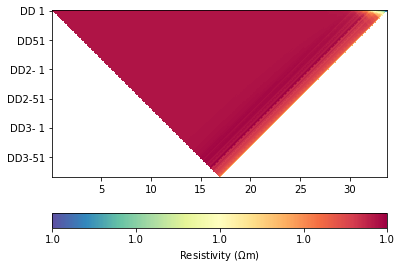

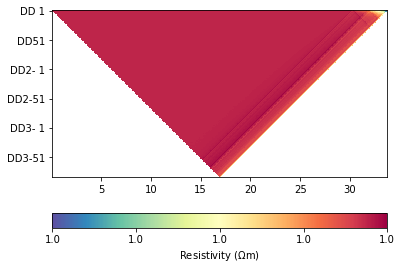

In [78]:
for i in range(10):
    ERT.showData(ertScheme, vals=rhoa[i]/rhoa[0])
                 #, cMin=1e-5, cMax=1)

In [ ]:
#fig.savefig('images/pseudosection_subplots.png', bbox_inches='tight')